In [132]:

import warnings

warnings.filterwarnings("ignore", message="Add-one smoothing for f4 = 0")
warnings.filterwarnings("ignore", category=FutureWarning)


import pandas as pd

pd.options.mode.chained_assignment = None
pd.options.display.float_format = '{:.2f}'.format

import matplotlib.pyplot as plt

from copia.data import to_copia_dataset
from copia.estimators import diversity
from copia.rarefaction_extrapolation import species_accumulation
from copia.plot import accumulation_curve

More generally, I would like to see a robustness analysis on the estimator - this is an active area of research. IE use several different estimator methods and show the result is not dependent on which one is used.

At a minimum I would like to see that results don't (or possibly do which would require explanation) using Chao1 and Generalized Chao. As best I can tell more recent methods like Alroy's [2008] method for correcting for recency bias wouldn't work, but there are a lot of choices out there. This is supplemental material, but important. It would be required in my field. 

--> By robustness analysis, we understand that the reviewer requests a formal comparison of different estimators. In copia, a diverse set of alternative estimators have already been implemented (such as the jackknife): if we would bin, for instance, the producers by occupation level, we could run these on the groups in isolation and compare them the results of the Generalized Chao. [MIKE] [2h]


Formal comparison of different estimators

1) Chao1 
2) Generalized  [Already implemented]
3) Jacknife (if we would bin, for instance, the producers by occupation level, we could run these on the groups in isolation and compare them the results of the Generalized Chao.) - https://github.com/mikekestemont/copia

Copia is a statistical software package for estimating diversity and richness on the basis of abundance data. The package contains several bias-correcting richness estimators, such as the Chao1 and the Jacknife estimator.

In [133]:
# observations = 'duck', 'duck', 'eagle', 'dove', 'dove', 'dove', 'hawk', 'dove', 'dove'
# ds = to_copia_dataset(observations, data_type="abundance", input_type="observations")

# for method in ('chao1', 'ichao1', 'ace', 'jackknife', 'egghe_proot'):
#     print(method, '->', round(diversity(ds, method=method)))

# D = diversity(ds, method='chao1', CI=True, n_iter=100, n_jobs=1)

# accumulation = species_accumulation(ds, max_steps=1000, n_iter=100, step_size=10)
# fig, ax = plt.subplots(figsize=(6, 4))

# accumulation_curve(
#     ds, accumulation, ax=ax, xlabel="number of documents", ylabel="number of works");

#### Apply on normal data

In [136]:
df = pd.read_csv('unseen_species_model/unseen_species_model_bayesian.csv', index_col=[0])
sample = df.copy()
sample['count'] = sample['count'].astype(int)
#sample = sample.sample(2000, random_state=42)
sample['count'][sample['count']==0] = 1


# Initialize results list
results = []

# Process each region separately
for region in sample['region_name'].unique():
    region_data = sample[sample['region_name'] == region]
    
    # Group by decade and occupation directly (no binning)
    groups = region_data.groupby(['decade', 'occupation'])
    
    # Iterate through each group
    for (decade, occupation), group_data in groups:
        # Get counts for unique individuals in this group
        df_unique = group_data[['individual_wikidata_id', 'count']].drop_duplicates()
        
        individual_counts = df_unique.set_index('individual_wikidata_id')['count']
        individual_counts.index.name = None
        ds = to_copia_dataset(individual_counts, data_type="abundance", input_type="counts")
        
        chao1 = round(diversity(ds, method='chao1'))
        jackknife = round(diversity(ds, method='jackknife'))
        ichao1 = round(diversity(ds, method='ichao1'))
        # ace = round(diversity(ds, method='ace'))
        # egghe_proot = round(diversity(ds, method='egghe_proot')) #not stable
        
        # Add to results
        results.append({
            'region_name': region,
            'decade': decade,  # Use actual decade instead of binned value
            'occupation': occupation,
            'f1': ds.f1,
            'f2': ds.f2,
            'n': ds.n,
            'chao1': chao1,
            'jackknife': jackknife,
            'ichao1': ichao1,
            # 'ace': ace,
            # 'egghe_proot': egghe_proot
        })

# Create DataFrame from results
df_estimator = pd.DataFrame(results)

# Sort by region, decade, occupation
df_estimator = df_estimator.sort_values(['region_name', 'decade', 'occupation'])

df_estimator

,region_name,decade,occupation,f1,f2,n,chao1,jackknife,ichao1
2567,Arabic world,-610,Writer,1,0,1,1,1,1
2568,Arabic world,-400,Painter,1,0,1,1,1,1
2569,Arabic world,-360,Painter,1,0,1,1,1,1
2570,Arabic world,-360,Writer,1,1,3,2,3,2
2571,Arabic world,-330,Writer,0,1,2,1,1,1
...,...,...,...,...,...,...,...,...,...
3075,United Kingdom,1880,Musician,170,2,174,7355,342,7355
3076,United Kingdom,1880,Painter,377,37,451,2330,791,2330
3077,United Kingdom,1880,Performing Artist,33,1,35,563,67,563
3078,United Kingdom,1880,Sculptor,17,9,35,42,43,42


In [141]:
df_plot = df.copy()
df_plot = df_plot[['region_name', 'decade', 'occupation', 'f1', 'f2', 'f0']]
df_plot = df_plot.rename(columns={'f0':'gen_chao'})
df_plot['gen_chao'] = df_plot['gen_chao'].astype(int)
df_plot = df_plot.groupby(['region_name','decade', 'occupation']).sum().reset_index()
df_plot = pd.merge(df_plot, df_estimator, on = ['region_name', 'decade', 'occupation', 'f1', 'f2'])
df_plot['compare'] = df_plot['gen_chao'] <= df_plot['chao1']
# df_plot[df_plot['compare']==True]


### Compare estimators

In [ ]:
df_compare = df_plot.groupby('region_name')[['chao1', 'gen_chao', 'jackknife']].sum().reset_index()
df_compare['gen_chao'] = df_compare['gen_chao'].astype(int)
df_compare

,region_name,chao1,gen_chao,jackknife
0,Arabic world,7317,10377,1687
1,Central Europe,231145,330798,14326
2,Chinese world,14139,10026,2269
3,East Slavic,72309,100745,6540
4,France,229179,258488,32301
5,German world,1060441,918563,53619
6,Greek World,6241,13968,1489
7,Indian world,1593,3231,543
8,Italy,307258,406001,24455
9,Japan,6325,8029,1339


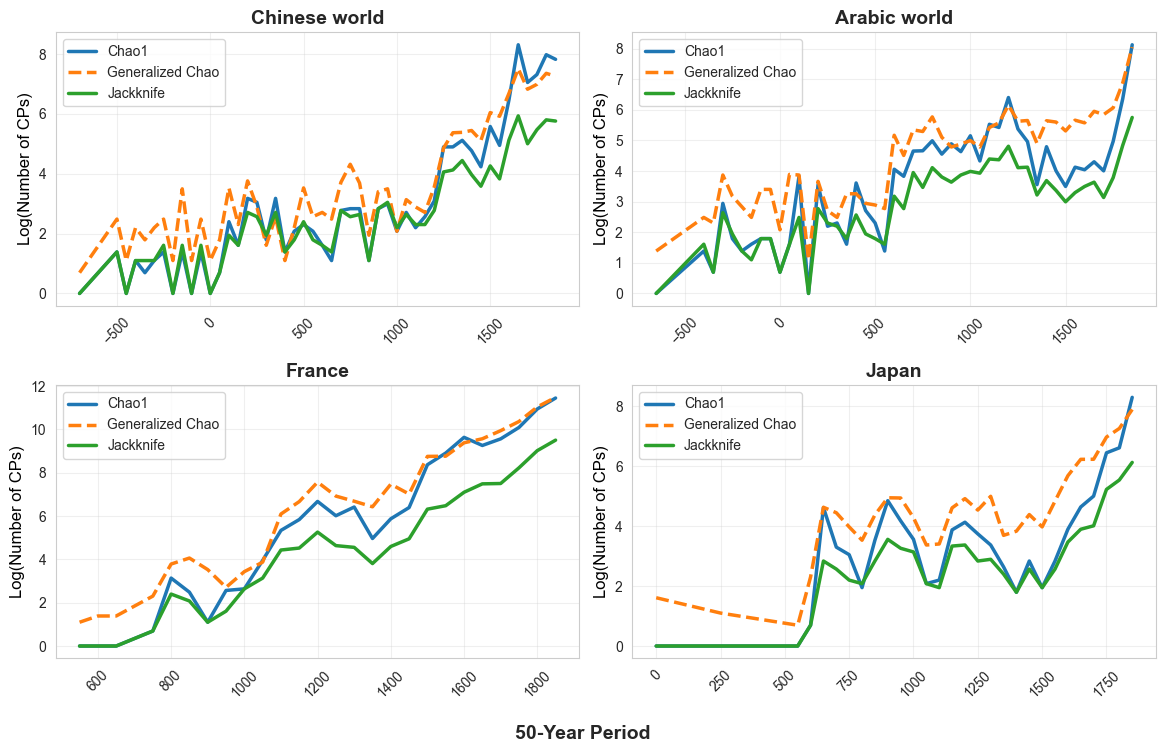

In [164]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from scipy.signal import savgol_filter

# Assuming df_plot is your original dataframe
# First filter to only include data from 1850 onwards

# Group by 50-year periods instead of decades
# Create a new column for the 50-year period


df_filtered = df_plot.copy()
df_filtered['period'] = (df_filtered['decade'] // 50) * 50

df_filtered = df_filtered[df_filtered['period'] <= 1850]

# Now group by this period instead of decade
df_regions = df_filtered.groupby(['region_name', 'period'])[['chao1', 'gen_chao', 'jackknife']].sum().reset_index()


# Select 4 interesting regions
regions_to_plot = ['Chinese world', 'Arabic world', 'France', 'Japan']

# Create a figure with subplots (2x2 grid)
fig, axes = plt.subplots(2, 2, figsize=(12, 8), sharex=False)
axes = axes.flatten()

# Set a color palette
colors = ['#1f77b4', '#ff7f0e', '#2ca02c']

# Function to apply smoothing
def smooth_data(y, window_size=5, poly_order=2):
    """Apply Savitzky-Golay filter for smoothing if enough data points"""
    if len(y) > window_size:
        # Make sure window_size is odd
        if window_size % 2 == 0:
            window_size += 1
        # Make sure poly_order < window_size
        poly_order = min(poly_order, window_size-1)
        return savgol_filter(y, window_size, poly_order)
    else:
        # Not enough points for smoothing, return original data
        return y

# Loop through the selected regions
for i, region in enumerate(regions_to_plot):
    # Filter data for this region
    region_data = df_regions[df_regions['region_name'] == region].sort_values('period')
    
    # Skip if no data
    if len(region_data) == 0:
        axes[i].text(0.5, 0.5, f"No data for {region}", 
                     ha='center', va='center', fontsize=14)
        continue
    
    periods = region_data['period'].values
    
    # Get the original values
    chao1 = region_data['chao1'].values
    gen_chao = region_data['gen_chao'].values
    jackknife = region_data['jackknife'].values
    
    # Apply log transformation to all values
    # Add small epsilon to avoid log(0)
    epsilon = 1e-10
    chao1_log = np.log(chao1 + epsilon)
    jackknife_log = np.log(jackknife + epsilon)
    gen_chao_log = np.log(gen_chao + epsilon)
    
    # Plot the log-transformed lines
    axes[i].plot(periods, chao1_log, color=colors[0], linewidth=2.5, label='Chao1')
    axes[i].plot(periods, gen_chao_log, color=colors[1], linewidth=2.5, linestyle='--', label='Generalized Chao')
    axes[i].plot(periods, jackknife_log, color=colors[2], linewidth=2.5, label='Jackknife')
    
    # Set title and y-axis label
    axes[i].set_title(f"{region}", fontsize=14, fontweight='bold')
    axes[i].set_ylabel('Log(Number of CPs)', fontsize=12, color='black')
    
    # Rotate x-axis labels for better readability
    axes[i].tick_params(axis='x', rotation=45)
    
    # Add legend
    axes[i].legend(loc='upper left')
    
    # Add grid for better readability
    axes[i].grid(True, alpha=0.3)

# Add a single x-axis label for the entire figure
fig.text(0.5, 0.02, '50-Year Period', ha='center', fontsize=14, fontweight='bold')

# Adjust layout
plt.tight_layout(rect=[0.01, 0.05, 0.99, 0.95])  # Make space for the common x-axis label

# Show plot
plt.show()

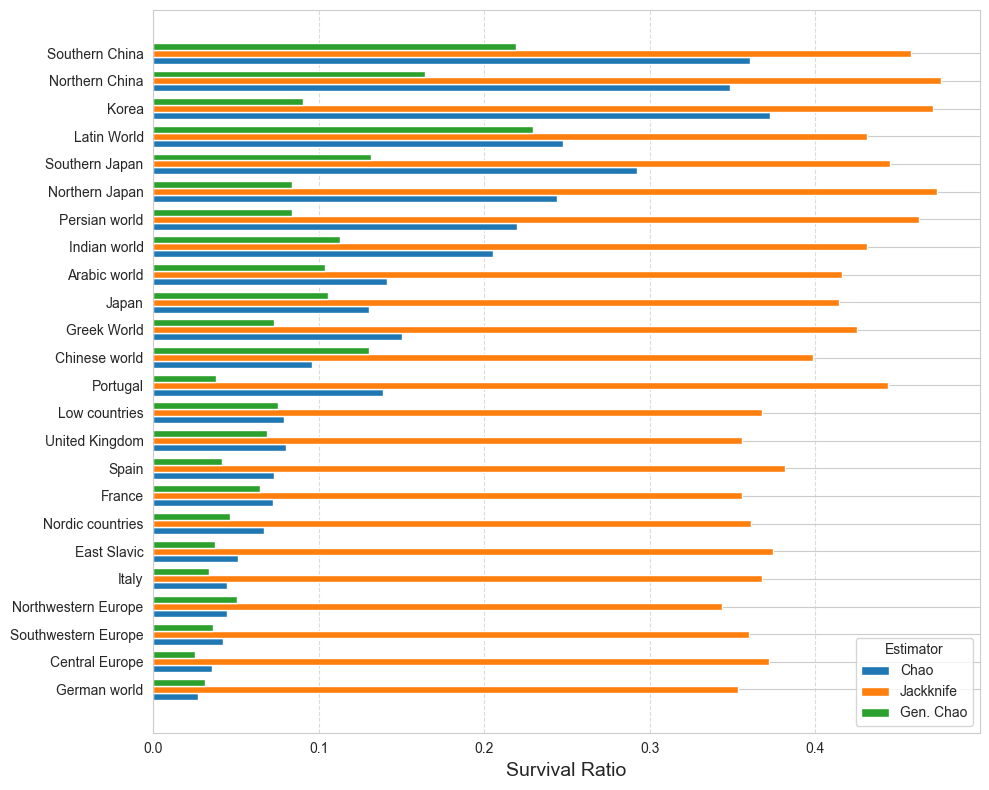

In [180]:

df_estimator = df_plot.groupby(['region_name']).agg({'gen_chao':'sum','chao1':'sum', 
                                                  'jackknife':'sum', 
                                                  'ichao1':'sum', 
                                                #   'ace':'sum', 
                                                #   'egghe_proot':'sum',
                                                  'f1':'sum', 
                                                  'f2':'sum', 
                                                  'n':'sum'}).reset_index()

df_estimator['total_chao'] = df_estimator['chao1'] + df_estimator['f1']+ df_estimator['f2']
df_estimator['total_jackknife'] = df_estimator['jackknife'] + df_estimator['f1']+ df_estimator['f2']
df_estimator['total_gen_chao'] = df_estimator['gen_chao'] + df_estimator['f1']+ df_estimator['f2']
df_estimator['S_obs'] = df_estimator['f1']+df_estimator['f2']

df_estimator['survival_ratio_chao']=df_estimator['S_obs']/df_estimator['total_chao']
df_estimator['survival_ratio_jackknife']=df_estimator['S_obs']/df_estimator['total_jackknife']
df_estimator['survival_ratio_gen_chao']=df_estimator['S_obs']/df_estimator['total_gen_chao']

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Extract relevant columns for plotting
plot_data = df_estimator[['region_name', 'survival_ratio_chao', 'survival_ratio_jackknife', 'survival_ratio_gen_chao']]

# Sort regions by average survival ratio
plot_data['avg_survival'] = plot_data[['survival_ratio_chao', 'survival_ratio_jackknife', 'survival_ratio_gen_chao']].mean(axis=1)
sorted_regions = plot_data.sort_values('avg_survival', ascending=True)['region_name'].tolist()

# Set up the figure
plt.figure(figsize=(10, 8))

# Set positions and width
y_positions = np.arange(len(sorted_regions))
width = 0.25

# Plot each estimator
plt.barh(y_positions - width, 
         [plot_data.loc[plot_data['region_name'] == region, 'survival_ratio_chao'].values[0] for region in sorted_regions], 
         height=width, label='Chao', color='#1f77b4')

plt.barh(y_positions, 
         [plot_data.loc[plot_data['region_name'] == region, 'survival_ratio_jackknife'].values[0] for region in sorted_regions], 
         height=width, label='Jackknife', color='#ff7f0e')

plt.barh(y_positions + width, 
         [plot_data.loc[plot_data['region_name'] == region, 'survival_ratio_gen_chao'].values[0] for region in sorted_regions], 
         height=width, label='Gen. Chao', color='#2ca02c')

# Set y-axis ticks and labels
plt.yticks(y_positions, sorted_regions)

# Add labels and title
plt.xlabel('Survival Ratio', fontsize=14)
plt.title('', fontsize=16)

# Add a legend
plt.legend(title='Estimator', loc='lower right')

# Add grid lines
plt.grid(axis='x', linestyle='--', alpha=0.7)

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()

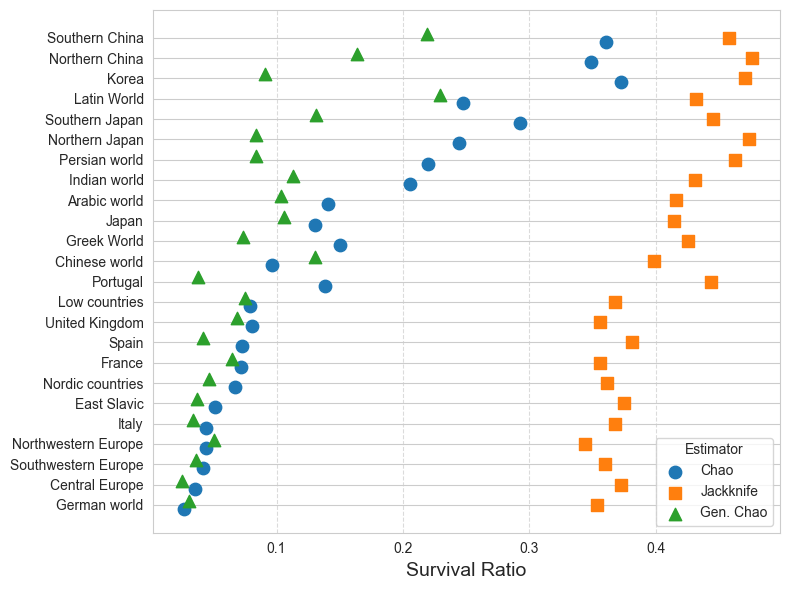

In [183]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Extract relevant columns for plotting
plot_data = df_estimator[['region_name', 'survival_ratio_chao', 'survival_ratio_jackknife', 'survival_ratio_gen_chao']]

# Sort regions by average survival ratio
plot_data['avg_survival'] = plot_data[['survival_ratio_chao', 'survival_ratio_jackknife', 'survival_ratio_gen_chao']].mean(axis=1)
sorted_regions = plot_data.sort_values('avg_survival', ascending=True)['region_name'].tolist()

# Set up the figure
plt.figure(figsize=(8, 6))

# Set positions
y_positions = np.arange(len(sorted_regions))
offset = 0.2  # Offset between points

# Get the values for each estimator
chao_values = [plot_data.loc[plot_data['region_name'] == region, 'survival_ratio_chao'].values[0] for region in sorted_regions]
jackknife_values = [plot_data.loc[plot_data['region_name'] == region, 'survival_ratio_jackknife'].values[0] for region in sorted_regions]
gen_chao_values = [plot_data.loc[plot_data['region_name'] == region, 'survival_ratio_gen_chao'].values[0] for region in sorted_regions]

# Plot each estimator with points
plt.scatter(chao_values, y_positions - offset, s=80, label='Chao', color='#1f77b4', marker='o')
plt.scatter(jackknife_values, y_positions, s=80, label='Jackknife', color='#ff7f0e', marker='s')
plt.scatter(gen_chao_values, y_positions + offset, s=80, label='Gen. Chao', color='#2ca02c', marker='^')

# Set y-axis ticks and labels
plt.yticks(y_positions, sorted_regions)

# Add labels and title
plt.xlabel('Survival Ratio', fontsize=14)

# Add a legend
plt.legend(title='Estimator', loc='lower right')

# Add grid lines
plt.grid(axis='x', linestyle='--', alpha=0.7)

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()

In [ ]:

# Generalize chao should always haev a larger f0 (sanity check)
# the normal chao should be more conservative than the jackknife
# look at the Science paper / or in time (timeline of western europe and show foir each time step the 4 estimators)
# the graoh where we ompare east to west for the three estimators.$
# do for occupations DONE

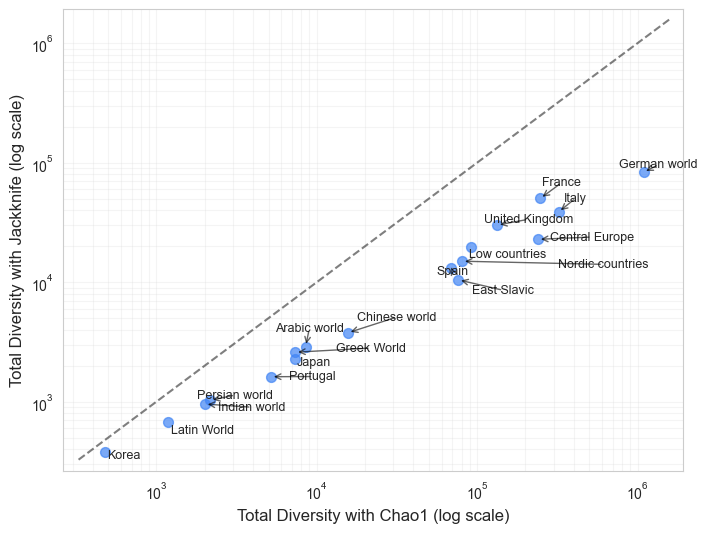

In [178]:
import matplotlib.pyplot as plt
import numpy as np
from adjustText import adjust_text  # This might need to be installed with pip install adjustText

# Filter out regions with "North" and "South" in their names
main_regions = [region for region in df_estimator['region_name'] 
               if not any(direction in region for direction in ["North", "South"])]
df_main = df_estimator[df_estimator['region_name'].isin(main_regions)]

# Create a figure for the log-scale scatter plot
plt.figure(figsize=(8, 6))  # Slightly larger figure to accommodate all labels

# Create scatter plot with larger points
scatter = plt.scatter(df_main['total_chao'], df_main['total_jackknife'], alpha=0.7, s=50, color='#4285F4')

# Set log scales for both axes
plt.xscale('log')
plt.yscale('log')

# Add labels and title
plt.xlabel('Total Diversity with Chao1 (log scale)', fontsize=12)
plt.ylabel('Total Diversity with Jackknife (log scale)', fontsize=12)

# Add a reference line (where Chao = Jackknife)
max_val = max(df_estimator['total_chao'].max(), df_estimator['total_jackknife'].max())
min_val = min(df_estimator['total_chao'].min(), df_estimator['total_jackknife'].min())
plt.plot([min_val, max_val], [min_val, max_val], 'k--', alpha=0.5)

# Create text annotations but don't add them yet
texts = []
for i, row in df_main.iterrows():
    texts.append(plt.text(row['total_chao'], row['total_jackknife'], row['region_name'], fontsize=9))

# Use adjust_text to prevent overlap
adjust_text(texts, 
           arrowprops=dict(arrowstyle='->', color='black', alpha=0.6),
           expand_points=(1.5, 1.5),
           force_points=(0.1, 0.1))

# Set axis limits with some padding
plt.xlim(min_val * 0.8, max_val * 1.2)
plt.ylim(min_val * 0.8, max_val * 1.2)

# Add grid for better readability
plt.grid(True, which="both", ls="-", alpha=0.2)
plt.show()

# Alternative approach if adjustText is not available:
# This manual approach uses specific positioning for problem regions



In [101]:
# compare chao1 and show that generalized chao is higher
# if not, it means that the model is not doing what it is supposed to do